In [1]:
%matplotlib inline

# Transit fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6


*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

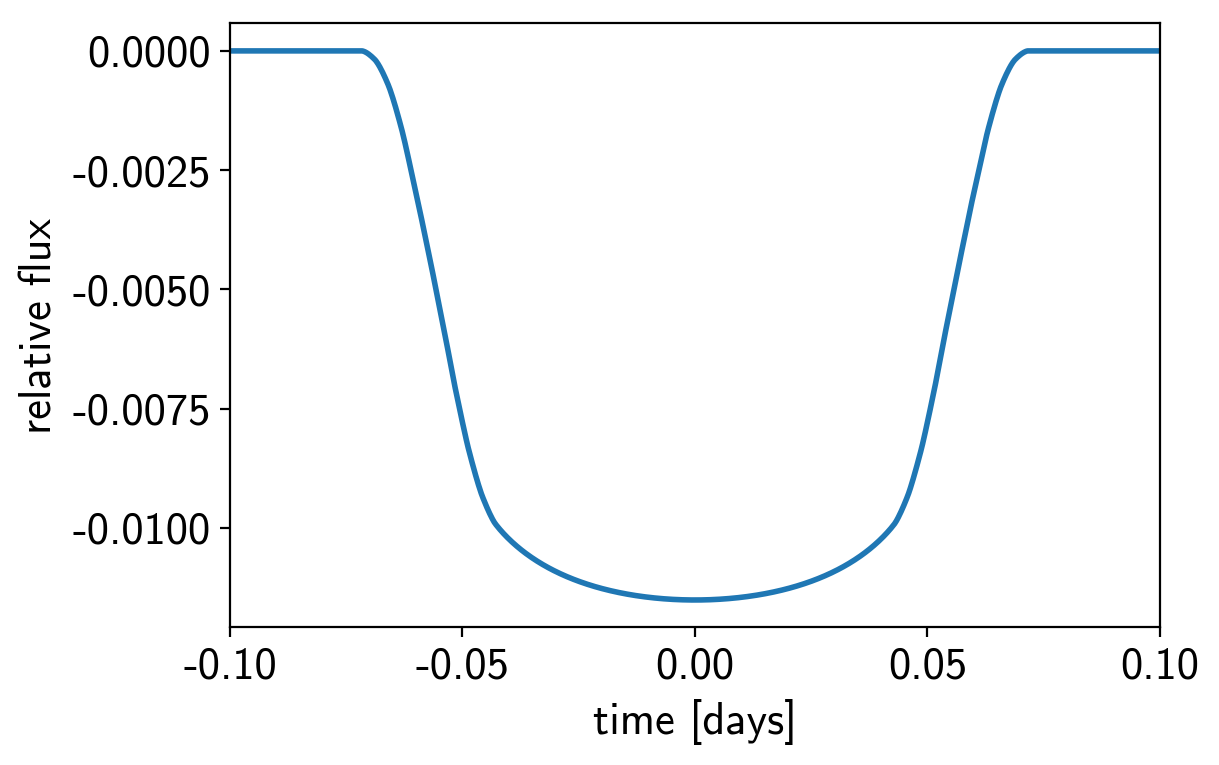

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.StarryLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.1,
        testval_r=np.array([0.04, 0.06]),
        testval_b=np.random.rand(2)
    )
    
    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.StarryLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 24793.972586707856 -> 24799.526978939903


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

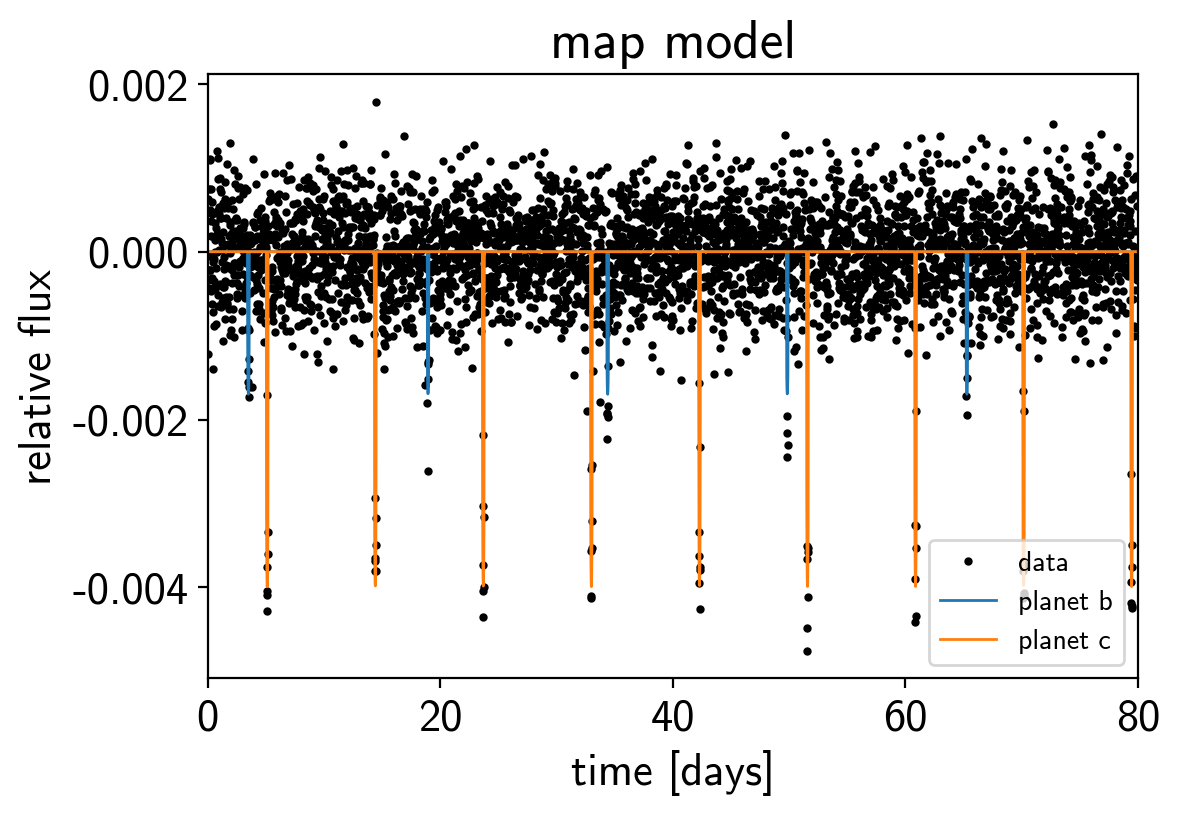

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:02, 98.80draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:00<00:05, 47.55draws/s]

Sampling 4 chains:   9%|▉         | 29/308 [00:00<00:07, 35.85draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:00<00:08, 30.56draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:00<00:09, 27.74draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:01<00:10, 25.57draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:01<00:10, 24.69draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:01<00:10, 24.11draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:01<00:10, 23.48draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:01<00:10, 24.70draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:01<00:10, 23.99draws/s]

Sampling 4 chains:  22%|██▏       | 67/308 [00:02<00:09, 25.01draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:02<00:10, 23.66draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:02<00:10, 23.28draws/s]

Sampling 4 chains:  26%|██▌       | 79/308 [00:02<00:09, 23.01draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:02<00:09, 22.81draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:03<00:09, 22.66draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:03<00:09, 22.20draws/s]

Sampling 4 chains:  31%|███       | 95/308 [00:03<00:09, 22.25draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:03<00:08, 23.16draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:03<00:08, 23.01draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:03<00:08, 22.94draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:04<00:08, 22.85draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:04<00:08, 22.82draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:04<00:08, 22.86draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:04<00:08, 22.90draws/s]

Sampling 4 chains:  41%|████      | 127/308 [00:04<00:07, 24.48draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:04<00:07, 23.43draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:05<00:07, 23.98draws/s]

Sampling 4 chains:  44%|████▍     | 136/308 [00:05<00:07, 21.77draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:05<00:07, 22.38draws/s]

Sampling 4 chains:  46%|████▌     | 142/308 [00:05<00:07, 22.26draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:05<00:06, 23.81draws/s]

Sampling 4 chains:  48%|████▊     | 148/308 [00:05<00:06, 23.51draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:05<00:06, 23.28draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [00:06<00:06, 23.05draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [00:06<00:06, 22.90draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [00:06<00:06, 22.80draws/s]

Sampling 4 chains:  54%|█████▍    | 167/308 [00:06<00:06, 22.72draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:06<00:06, 22.66draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:06<00:05, 22.64draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [00:07<00:05, 22.37draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [00:07<00:05, 22.41draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [00:07<00:05, 22.43draws/s]

Sampling 4 chains:  62%|██████▏   | 191/308 [00:07<00:05, 22.46draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [00:07<00:05, 22.38draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [00:07<00:04, 24.21draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:08<00:04, 24.32draws/s]

Sampling 4 chains:  66%|██████▌   | 204/308 [00:08<00:04, 22.09draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:08<00:04, 21.56draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:08<00:04, 22.81draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [00:08<00:03, 23.89draws/s]

Sampling 4 chains:  70%|███████   | 216/308 [00:08<00:04, 22.58draws/s]

Sampling 4 chains:  71%|███████   | 219/308 [00:08<00:04, 21.46draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [00:09<00:03, 22.10draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:09<00:03, 22.10draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:09<00:03, 22.01draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [00:09<00:03, 22.02draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [00:09<00:03, 22.04draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:09<00:02, 22.04draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:10<00:02, 22.05draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:10<00:02, 22.05draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:10<00:02, 22.06draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:10<00:02, 22.07draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:10<00:02, 22.22draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:10<00:01, 22.44draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:11<00:01, 22.61draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:11<00:01, 22.73draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:11<00:01, 22.70draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:11<00:01, 22.78draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:11<00:00, 22.84draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:12<00:00, 22.79draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:12<00:00, 22.85draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:12<00:00, 22.90draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [00:12<00:00, 18.72draws/s]

Sampling 4 chains:  98%|█████████▊| 303/308 [00:12<00:00, 15.64draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:12<00:00, 14.29draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:13<00:00,  7.62draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:13<00:00, 22.62draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:03, 99.66draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:07, 49.44draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:10, 36.58draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:11, 33.71draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:00<00:12, 29.48draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:12, 29.08draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:01<00:13, 26.89draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:01<00:13, 25.56draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:01<00:12, 27.65draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:01<00:13, 25.74draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:01<00:13, 25.85draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:02<00:13, 25.57draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:02<00:12, 25.91draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:02<00:11, 27.68draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:02<00:12, 25.69draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:02<00:12, 26.11draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:03<00:11, 26.50draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:03<00:12, 24.97draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:03<00:12, 23.73draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:03<00:12, 23.42draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:03<00:12, 23.22draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:04<00:12, 22.99draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:04<00:12, 22.90draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:04<00:11, 25.37draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:04<00:11, 24.52draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:04<00:10, 25.42draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:04<00:10, 26.27draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:05<00:09, 26.67draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:05<00:10, 25.32draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:05<00:09, 26.19draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:05<00:09, 25.06draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:05<00:10, 24.33draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:05<00:09, 25.32draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:06<00:10, 22.24draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:06<00:11, 20.28draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:06<00:11, 20.87draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:06<00:10, 22.59draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:06<00:09, 22.53draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:06<00:09, 22.49draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:07<00:09, 22.40draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:07<00:08, 24.77draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:07<00:08, 24.04draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:07<00:08, 25.10draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:07<00:08, 24.28draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:08<00:08, 23.74draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:08<00:08, 23.18draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:08<00:08, 22.96draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:08<00:07, 24.29draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:08<00:07, 23.73draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:08<00:07, 23.19draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:09<00:07, 22.98draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:09<00:06, 24.33draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:09<00:06, 23.78draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:09<00:06, 23.40draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:09<00:06, 23.07draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:09<00:05, 24.40draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:10<00:05, 23.82draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:10<00:05, 23.43draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:10<00:05, 24.67draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:10<00:05, 25.68draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:10<00:05, 24.46draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:10<00:04, 25.31draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:11<00:04, 24.23draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:11<00:04, 25.14draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:11<00:03, 26.87draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:11<00:04, 25.21draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:11<00:04, 24.16draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:12<00:04, 23.49draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:12<00:03, 24.41draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:12<00:03, 23.65draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:12<00:03, 23.13draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:12<00:03, 22.79draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:12<00:03, 23.86draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:13<00:02, 23.25draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:13<00:02, 22.86draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:13<00:02, 22.59draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:13<00:02, 22.41draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:13<00:02, 24.80draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:14<00:01, 23.87draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:14<00:01, 23.29draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:14<00:01, 23.02draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:14<00:01, 22.81draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:14<00:01, 22.73draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:14<00:01, 24.14draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:15<00:00, 23.64draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:15<00:00, 23.31draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:15<00:00, 23.08draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:15<00:00, 14.37draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:16<00:00, 13.16draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:16<00:00, 13.50draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:16<00:00, 11.71draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:16<00:00,  8.75draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:17<00:00,  4.63draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:26,  9.29draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<01:05, 12.31draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:50, 15.72draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:41, 19.10draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:00<00:34, 22.97draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:00<00:32, 24.11draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:00<00:33, 23.46draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:01<00:33, 22.99draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:01<00:31, 24.68draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:01<00:31, 24.02draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:01<00:30, 25.40draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:01<00:31, 23.76draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:01<00:34, 21.63draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:01<00:31, 24.26draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:02<00:28, 26.40draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:02<00:29, 25.08draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:02<00:27, 26.69draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:02<00:27, 27.22draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:02<00:31, 23.36draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:02<00:28, 25.77draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:02<00:28, 25.63draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:03<00:29, 24.58draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:03<00:28, 25.42draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:03<00:25, 28.10draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:03<00:22, 32.30draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:03<00:22, 30.77draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:03<00:21, 32.76draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:03<00:24, 28.99draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:04<00:24, 28.41draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:04<00:26, 26.02draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:04<00:24, 28.08draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:04<00:24, 27.74draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:04<00:26, 25.79draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:04<00:22, 30.23draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:04<00:21, 30.28draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:05<00:22, 29.97draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:05<00:20, 31.88draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:05<00:18, 35.76draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:05<00:17, 36.84draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:05<00:18, 33.75draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:05<00:19, 32.42draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:05<00:18, 34.22draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:05<00:18, 34.78draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:06<00:15, 38.93draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:06<00:17, 34.95draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:06<00:15, 38.63draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:06<00:17, 34.60draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:06<00:17, 35.11draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:06<00:20, 29.65draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:07<00:19, 31.10draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:07<00:21, 27.74draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:07<00:19, 29.23draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:07<00:21, 26.66draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:07<00:19, 29.82draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:07<00:18, 31.63draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:07<00:20, 27.82draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:08<00:19, 29.06draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:08<00:18, 30.68draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:08<00:20, 27.43draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:08<00:17, 31.90draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:08<00:16, 33.15draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:08<00:18, 29.73draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:09<00:20, 26.57draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:09<00:21, 25.03draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:09<00:17, 29.31draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:09<00:15, 32.87draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:09<00:16, 31.96draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:09<00:15, 32.04draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:09<00:15, 33.15draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:09<00:16, 30.61draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:10<00:15, 31.41draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:10<00:17, 28.04draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:10<00:15, 30.40draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:10<00:14, 32.55draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:10<00:16, 28.41draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:10<00:17, 27.33draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:11<00:17, 26.58draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:11<00:17, 26.18draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:11<00:17, 26.68draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:11<00:15, 28.98draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:11<00:17, 26.47draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:11<00:16, 27.34draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:12<00:14, 30.71draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:12<00:15, 27.63draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:12<00:15, 27.72draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:12<00:16, 25.76draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:12<00:15, 26.80draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:12<00:12, 32.53draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:12<00:14, 29.29draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:13<00:15, 26.29draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:13<00:14, 27.96draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:13<00:15, 25.83draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:13<00:14, 28.33draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:13<00:13, 28.56draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:13<00:13, 27.91draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:13<00:14, 26.67draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:14<00:15, 24.40draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:14<00:14, 26.71draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:14<00:14, 26.17draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:14<00:14, 26.19draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:14<00:14, 25.00draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:14<00:15, 24.19draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [00:15<00:15, 23.67draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:15<00:13, 26.34draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:15<00:12, 28.28draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:15<00:12, 27.96draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:15<00:14, 23.75draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:15<00:12, 26.67draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:15<00:12, 27.87draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:15<00:10, 32.13draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:16<00:09, 33.69draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:16<00:09, 35.02draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:16<00:10, 31.00draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:16<00:10, 31.33draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:16<00:10, 30.85draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:16<00:10, 28.35draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [00:16<00:11, 26.43draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:17<00:10, 29.41draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:17<00:09, 31.30draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:17<00:10, 28.71draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:17<00:10, 27.89draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:17<00:10, 27.69draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:17<00:08, 32.31draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:17<00:07, 35.04draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:18<00:07, 36.11draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:18<00:07, 32.81draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:18<00:07, 35.62draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:18<00:07, 32.68draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:18<00:08, 30.11draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:18<00:07, 30.94draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:18<00:06, 35.52draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:19<00:06, 34.41draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:19<00:05, 38.99draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:19<00:06, 35.30draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:19<00:05, 36.51draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:19<00:06, 32.98draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:19<00:06, 32.31draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:20<00:06, 31.85draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:20<00:05, 36.85draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:20<00:05, 34.92draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [00:20<00:05, 35.94draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:20<00:05, 32.95draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:20<00:06, 28.81draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:20<00:06, 26.52draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:21<00:06, 25.12draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:21<00:06, 24.25draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:21<00:06, 25.86draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:21<00:05, 26.74draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:21<00:05, 29.26draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:21<00:04, 30.51draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:21<00:04, 31.38draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:22<00:04, 27.76draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:22<00:05, 24.81draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:22<00:04, 27.63draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:22<00:04, 31.37draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [00:22<00:04, 27.75draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:22<00:04, 25.38draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:23<00:03, 28.01draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:23<00:03, 27.90draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:23<00:03, 30.56draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:23<00:03, 27.44draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:23<00:03, 26.57draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:23<00:03, 30.08draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:23<00:03, 26.95draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:24<00:02, 28.55draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [00:24<00:02, 28.32draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:24<00:02, 30.95draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:24<00:02, 27.74draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:24<00:02, 25.85draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:24<00:02, 26.41draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:24<00:02, 25.09draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:25<00:02, 24.77draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:25<00:02, 23.19draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:25<00:01, 25.90draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:25<00:01, 22.06draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:25<00:01, 25.16draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:25<00:01, 24.24draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:26<00:01, 23.67draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:26<00:01, 21.08draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:26<00:01, 22.41draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:26<00:00, 24.15draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:26<00:00, 24.65draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:26<00:00, 21.72draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:26<00:00, 23.26draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:27<00:00, 20.42draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:27<00:00, 18.57draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:27<00:00, 13.19draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:27<00:00, 12.72draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:27<00:00, 12.52draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:28<00:00, 28.41draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:00<00:07, 217.61draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:00<00:06, 248.27draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:00<00:05, 267.33draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:00<00:05, 290.90draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:00<00:04, 295.67draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:00<00:04, 310.11draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:00<00:04, 329.75draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:00<00:03, 333.87draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:00<00:03, 344.87draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:01<00:03, 333.08draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:01<00:03, 342.88draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [00:01<00:03, 355.77draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:01<00:03, 359.56draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [00:01<00:02, 369.74draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [00:01<00:02, 369.63draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:01<00:02, 370.10draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [00:01<00:02, 372.37draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [00:01<00:02, 370.89draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [00:01<00:02, 369.47draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [00:02<00:02, 379.07draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [00:02<00:02, 371.93draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [00:02<00:02, 365.95draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [00:02<00:02, 368.53draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [00:02<00:01, 383.00draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [00:02<00:01, 380.28draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [00:02<00:01, 387.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [00:02<00:01, 375.21draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [00:02<00:01, 353.49draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [00:03<00:01, 357.40draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [00:03<00:01, 381.42draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [00:03<00:01, 383.05draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [00:03<00:01, 361.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [00:03<00:00, 383.02draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [00:03<00:00, 387.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [00:03<00:00, 379.75draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [00:03<00:00, 383.38draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [00:03<00:00, 371.99draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [00:03<00:00, 383.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [00:04<00:00, 390.21draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [00:04<00:00, 403.29draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [00:04<00:00, 351.11draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:04<00:00, 347.93draws/s]

Sampling 4 chains:   0%|          | 0/6908 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/6908 [00:00<00:34, 202.03draws/s]

Sampling 4 chains:   1%|          | 48/6908 [00:00<00:31, 217.65draws/s]

Sampling 4 chains:   1%|          | 75/6908 [00:00<00:29, 230.56draws/s]

Sampling 4 chains:   2%|▏         | 104/6908 [00:00<00:27, 245.14draws/s]

Sampling 4 chains:   2%|▏         | 141/6908 [00:00<00:25, 267.18draws/s]

Sampling 4 chains:   2%|▏         | 166/6908 [00:00<00:27, 248.51draws/s]

Sampling 4 chains:   3%|▎         | 193/6908 [00:00<00:26, 249.53draws/s]

Sampling 4 chains:   3%|▎         | 224/6908 [00:00<00:25, 264.30draws/s]

Sampling 4 chains:   4%|▎         | 251/6908 [00:00<00:25, 264.82draws/s]

Sampling 4 chains:   4%|▍         | 278/6908 [00:01<00:25, 263.49draws/s]

Sampling 4 chains:   4%|▍         | 307/6908 [00:01<00:24, 267.75draws/s]

Sampling 4 chains:   5%|▍         | 338/6908 [00:01<00:23, 277.03draws/s]

Sampling 4 chains:   5%|▌         | 370/6908 [00:01<00:22, 285.01draws/s]

Sampling 4 chains:   6%|▌         | 399/6908 [00:01<00:23, 281.34draws/s]

Sampling 4 chains:   6%|▌         | 430/6908 [00:01<00:22, 285.97draws/s]

Sampling 4 chains:   7%|▋         | 464/6908 [00:01<00:21, 299.83draws/s]

Sampling 4 chains:   7%|▋         | 495/6908 [00:01<00:22, 288.71draws/s]

Sampling 4 chains:   8%|▊         | 530/6908 [00:01<00:21, 301.75draws/s]

Sampling 4 chains:   8%|▊         | 565/6908 [00:01<00:20, 314.17draws/s]

Sampling 4 chains:   9%|▊         | 601/6908 [00:02<00:19, 324.74draws/s]

Sampling 4 chains:   9%|▉         | 635/6908 [00:02<00:19, 327.67draws/s]

Sampling 4 chains:  10%|▉         | 669/6908 [00:02<00:19, 325.46draws/s]

Sampling 4 chains:  10%|█         | 702/6908 [00:02<00:20, 307.71draws/s]

Sampling 4 chains:  11%|█         | 741/6908 [00:02<00:19, 324.56draws/s]

Sampling 4 chains:  11%|█         | 775/6908 [00:02<00:18, 327.38draws/s]

Sampling 4 chains:  12%|█▏        | 811/6908 [00:02<00:18, 335.97draws/s]

Sampling 4 chains:  12%|█▏        | 848/6908 [00:02<00:17, 344.96draws/s]

Sampling 4 chains:  13%|█▎        | 886/6908 [00:02<00:16, 354.25draws/s]

Sampling 4 chains:  13%|█▎        | 922/6908 [00:03<00:17, 346.92draws/s]

Sampling 4 chains:  14%|█▍        | 959/6908 [00:03<00:17, 348.40draws/s]

Sampling 4 chains:  14%|█▍        | 997/6908 [00:03<00:16, 356.05draws/s]

Sampling 4 chains:  15%|█▍        | 1033/6908 [00:03<00:16, 351.85draws/s]

Sampling 4 chains:  15%|█▌        | 1069/6908 [00:03<00:16, 351.52draws/s]

Sampling 4 chains:  16%|█▌        | 1105/6908 [00:03<00:16, 352.88draws/s]

Sampling 4 chains:  17%|█▋        | 1143/6908 [00:03<00:16, 357.93draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6908 [00:03<00:15, 358.35draws/s]

Sampling 4 chains:  18%|█▊        | 1216/6908 [00:03<00:15, 361.35draws/s]

Sampling 4 chains:  18%|█▊        | 1254/6908 [00:03<00:15, 361.57draws/s]

Sampling 4 chains:  19%|█▊        | 1291/6908 [00:04<00:15, 354.15draws/s]

Sampling 4 chains:  19%|█▉        | 1327/6908 [00:04<00:16, 344.63draws/s]

Sampling 4 chains:  20%|█▉        | 1362/6908 [00:04<00:16, 344.28draws/s]

Sampling 4 chains:  20%|██        | 1397/6908 [00:04<00:16, 335.59draws/s]

Sampling 4 chains:  21%|██        | 1432/6908 [00:04<00:16, 336.71draws/s]

Sampling 4 chains:  21%|██        | 1466/6908 [00:04<00:16, 328.41draws/s]

Sampling 4 chains:  22%|██▏       | 1500/6908 [00:04<00:16, 329.02draws/s]

Sampling 4 chains:  22%|██▏       | 1534/6908 [00:04<00:16, 329.93draws/s]

Sampling 4 chains:  23%|██▎       | 1568/6908 [00:04<00:16, 325.79draws/s]

Sampling 4 chains:  23%|██▎       | 1602/6908 [00:05<00:16, 328.01draws/s]

Sampling 4 chains:  24%|██▎       | 1640/6908 [00:05<00:15, 340.46draws/s]

Sampling 4 chains:  24%|██▍       | 1677/6908 [00:05<00:15, 347.28draws/s]

Sampling 4 chains:  25%|██▍       | 1714/6908 [00:05<00:14, 351.76draws/s]

Sampling 4 chains:  25%|██▌       | 1750/6908 [00:05<00:14, 350.42draws/s]

Sampling 4 chains:  26%|██▌       | 1786/6908 [00:05<00:14, 342.74draws/s]

Sampling 4 chains:  26%|██▋       | 1821/6908 [00:05<00:14, 342.66draws/s]

Sampling 4 chains:  27%|██▋       | 1856/6908 [00:05<00:14, 342.00draws/s]

Sampling 4 chains:  27%|██▋       | 1896/6908 [00:05<00:14, 354.83draws/s]

Sampling 4 chains:  28%|██▊       | 1936/6908 [00:05<00:13, 366.58draws/s]

Sampling 4 chains:  29%|██▊       | 1973/6908 [00:06<00:13, 366.42draws/s]

Sampling 4 chains:  29%|██▉       | 2010/6908 [00:06<00:14, 339.34draws/s]

Sampling 4 chains:  30%|██▉       | 2048/6908 [00:06<00:13, 348.14draws/s]

Sampling 4 chains:  30%|███       | 2086/6908 [00:06<00:13, 354.72draws/s]

Sampling 4 chains:  31%|███       | 2122/6908 [00:06<00:13, 349.88draws/s]

Sampling 4 chains:  31%|███       | 2158/6908 [00:06<00:13, 341.87draws/s]

Sampling 4 chains:  32%|███▏      | 2193/6908 [00:06<00:13, 342.80draws/s]

Sampling 4 chains:  32%|███▏      | 2233/6908 [00:06<00:13, 357.42draws/s]

Sampling 4 chains:  33%|███▎      | 2270/6908 [00:06<00:12, 358.86draws/s]

Sampling 4 chains:  33%|███▎      | 2310/6908 [00:07<00:12, 368.58draws/s]

Sampling 4 chains:  34%|███▍      | 2348/6908 [00:07<00:12, 355.37draws/s]

Sampling 4 chains:  35%|███▍      | 2384/6908 [00:07<00:12, 353.46draws/s]

Sampling 4 chains:  35%|███▌      | 2423/6908 [00:07<00:12, 362.59draws/s]

Sampling 4 chains:  36%|███▌      | 2460/6908 [00:07<00:12, 352.85draws/s]

Sampling 4 chains:  36%|███▌      | 2498/6908 [00:07<00:12, 359.88draws/s]

Sampling 4 chains:  37%|███▋      | 2535/6908 [00:07<00:12, 355.60draws/s]

Sampling 4 chains:  37%|███▋      | 2571/6908 [00:07<00:12, 353.38draws/s]

Sampling 4 chains:  38%|███▊      | 2610/6908 [00:07<00:11, 362.96draws/s]

Sampling 4 chains:  38%|███▊      | 2650/6908 [00:07<00:11, 366.73draws/s]

Sampling 4 chains:  39%|███▉      | 2687/6908 [00:08<00:11, 362.02draws/s]

Sampling 4 chains:  39%|███▉      | 2725/6908 [00:08<00:11, 364.91draws/s]

Sampling 4 chains:  40%|████      | 2767/6908 [00:08<00:10, 378.72draws/s]

Sampling 4 chains:  41%|████      | 2806/6908 [00:08<00:10, 374.31draws/s]

Sampling 4 chains:  41%|████      | 2846/6908 [00:08<00:10, 380.95draws/s]

Sampling 4 chains:  42%|████▏     | 2885/6908 [00:08<00:10, 366.17draws/s]

Sampling 4 chains:  42%|████▏     | 2923/6908 [00:08<00:10, 368.76draws/s]

Sampling 4 chains:  43%|████▎     | 2961/6908 [00:08<00:10, 368.98draws/s]

Sampling 4 chains:  43%|████▎     | 2999/6908 [00:08<00:11, 351.90draws/s]

Sampling 4 chains:  44%|████▍     | 3039/6908 [00:09<00:10, 363.31draws/s]

Sampling 4 chains:  45%|████▍     | 3081/6908 [00:09<00:10, 378.34draws/s]

Sampling 4 chains:  45%|████▌     | 3120/6908 [00:09<00:10, 367.90draws/s]

Sampling 4 chains:  46%|████▌     | 3159/6908 [00:09<00:10, 370.93draws/s]

Sampling 4 chains:  46%|████▋     | 3197/6908 [00:09<00:10, 357.38draws/s]

Sampling 4 chains:  47%|████▋     | 3237/6908 [00:09<00:09, 367.48draws/s]

Sampling 4 chains:  47%|████▋     | 3278/6908 [00:09<00:09, 377.87draws/s]

Sampling 4 chains:  48%|████▊     | 3317/6908 [00:09<00:09, 373.74draws/s]

Sampling 4 chains:  49%|████▊     | 3355/6908 [00:09<00:09, 373.16draws/s]

Sampling 4 chains:  49%|████▉     | 3394/6908 [00:09<00:09, 375.59draws/s]

Sampling 4 chains:  50%|████▉     | 3432/6908 [00:10<00:09, 376.22draws/s]

Sampling 4 chains:  50%|█████     | 3470/6908 [00:10<00:09, 360.85draws/s]

Sampling 4 chains:  51%|█████     | 3510/6908 [00:10<00:09, 371.19draws/s]

Sampling 4 chains:  51%|█████▏    | 3549/6908 [00:10<00:08, 375.41draws/s]

Sampling 4 chains:  52%|█████▏    | 3587/6908 [00:10<00:08, 372.79draws/s]

Sampling 4 chains:  52%|█████▏    | 3625/6908 [00:10<00:09, 361.53draws/s]

Sampling 4 chains:  53%|█████▎    | 3662/6908 [00:10<00:09, 357.24draws/s]

Sampling 4 chains:  54%|█████▎    | 3699/6908 [00:10<00:08, 359.38draws/s]

Sampling 4 chains:  54%|█████▍    | 3736/6908 [00:10<00:08, 361.53draws/s]

Sampling 4 chains:  55%|█████▍    | 3773/6908 [00:11<00:08, 361.63draws/s]

Sampling 4 chains:  55%|█████▌    | 3812/6908 [00:11<00:08, 369.39draws/s]

Sampling 4 chains:  56%|█████▌    | 3850/6908 [00:11<00:08, 364.23draws/s]

Sampling 4 chains:  56%|█████▋    | 3887/6908 [00:11<00:08, 360.23draws/s]

Sampling 4 chains:  57%|█████▋    | 3924/6908 [00:11<00:08, 361.35draws/s]

Sampling 4 chains:  57%|█████▋    | 3961/6908 [00:11<00:08, 363.40draws/s]

Sampling 4 chains:  58%|█████▊    | 3998/6908 [00:11<00:07, 364.12draws/s]

Sampling 4 chains:  58%|█████▊    | 4036/6908 [00:11<00:07, 366.85draws/s]

Sampling 4 chains:  59%|█████▉    | 4073/6908 [00:11<00:07, 361.78draws/s]

Sampling 4 chains:  59%|█████▉    | 4110/6908 [00:11<00:07, 363.18draws/s]

Sampling 4 chains:  60%|██████    | 4148/6908 [00:12<00:07, 366.90draws/s]

Sampling 4 chains:  61%|██████    | 4185/6908 [00:12<00:07, 366.36draws/s]

Sampling 4 chains:  61%|██████    | 4222/6908 [00:12<00:07, 363.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4259/6908 [00:12<00:07, 353.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4296/6908 [00:12<00:07, 355.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4335/6908 [00:12<00:07, 364.32draws/s]

Sampling 4 chains:  63%|██████▎   | 4375/6908 [00:12<00:06, 374.26draws/s]

Sampling 4 chains:  64%|██████▍   | 4417/6908 [00:12<00:06, 385.78draws/s]

Sampling 4 chains:  65%|██████▍   | 4456/6908 [00:12<00:06, 364.03draws/s]

Sampling 4 chains:  65%|██████▌   | 4493/6908 [00:12<00:06, 361.66draws/s]

Sampling 4 chains:  66%|██████▌   | 4530/6908 [00:13<00:06, 356.30draws/s]

Sampling 4 chains:  66%|██████▌   | 4570/6908 [00:13<00:06, 366.91draws/s]

Sampling 4 chains:  67%|██████▋   | 4608/6908 [00:13<00:06, 369.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4650/6908 [00:13<00:05, 382.45draws/s]

Sampling 4 chains:  68%|██████▊   | 4692/6908 [00:13<00:05, 391.28draws/s]

Sampling 4 chains:  69%|██████▊   | 4732/6908 [00:13<00:05, 383.16draws/s]

Sampling 4 chains:  69%|██████▉   | 4772/6908 [00:13<00:05, 387.68draws/s]

Sampling 4 chains:  70%|██████▉   | 4811/6908 [00:13<00:05, 378.40draws/s]

Sampling 4 chains:  70%|███████   | 4849/6908 [00:13<00:05, 370.84draws/s]

Sampling 4 chains:  71%|███████   | 4887/6908 [00:14<00:05, 371.69draws/s]

Sampling 4 chains:  71%|███████▏  | 4925/6908 [00:14<00:05, 362.93draws/s]

Sampling 4 chains:  72%|███████▏  | 4962/6908 [00:14<00:05, 362.44draws/s]

Sampling 4 chains:  72%|███████▏  | 5001/6908 [00:14<00:05, 368.18draws/s]

Sampling 4 chains:  73%|███████▎  | 5038/6908 [00:14<00:05, 361.61draws/s]

Sampling 4 chains:  73%|███████▎  | 5075/6908 [00:14<00:05, 356.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5111/6908 [00:14<00:05, 344.34draws/s]

Sampling 4 chains:  75%|███████▍  | 5148/6908 [00:14<00:05, 348.10draws/s]

Sampling 4 chains:  75%|███████▌  | 5183/6908 [00:14<00:05, 340.39draws/s]

Sampling 4 chains:  76%|███████▌  | 5226/6908 [00:14<00:04, 363.05draws/s]

Sampling 4 chains:  76%|███████▌  | 5267/6908 [00:15<00:04, 373.88draws/s]

Sampling 4 chains:  77%|███████▋  | 5305/6908 [00:15<00:04, 372.62draws/s]

Sampling 4 chains:  77%|███████▋  | 5343/6908 [00:15<00:04, 364.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5381/6908 [00:15<00:04, 368.28draws/s]

Sampling 4 chains:  78%|███████▊  | 5419/6908 [00:15<00:04, 368.31draws/s]

Sampling 4 chains:  79%|███████▉  | 5456/6908 [00:15<00:03, 363.98draws/s]

Sampling 4 chains:  80%|███████▉  | 5493/6908 [00:15<00:03, 363.60draws/s]

Sampling 4 chains:  80%|████████  | 5530/6908 [00:15<00:03, 364.33draws/s]

Sampling 4 chains:  81%|████████  | 5567/6908 [00:15<00:03, 351.38draws/s]

Sampling 4 chains:  81%|████████  | 5604/6908 [00:16<00:03, 356.43draws/s]

Sampling 4 chains:  82%|████████▏ | 5640/6908 [00:16<00:03, 352.92draws/s]

Sampling 4 chains:  82%|████████▏ | 5679/6908 [00:16<00:03, 362.58draws/s]

Sampling 4 chains:  83%|████████▎ | 5716/6908 [00:16<00:03, 363.37draws/s]

Sampling 4 chains:  83%|████████▎ | 5757/6908 [00:16<00:03, 375.42draws/s]

Sampling 4 chains:  84%|████████▍ | 5796/6908 [00:16<00:02, 378.01draws/s]

Sampling 4 chains:  84%|████████▍ | 5834/6908 [00:16<00:02, 377.62draws/s]

Sampling 4 chains:  85%|████████▌ | 5874/6908 [00:16<00:02, 383.29draws/s]

Sampling 4 chains:  86%|████████▌ | 5913/6908 [00:16<00:02, 374.73draws/s]

Sampling 4 chains:  86%|████████▌ | 5951/6908 [00:16<00:02, 375.01draws/s]

Sampling 4 chains:  87%|████████▋ | 5989/6908 [00:17<00:02, 374.05draws/s]

Sampling 4 chains:  87%|████████▋ | 6027/6908 [00:17<00:02, 367.50draws/s]

Sampling 4 chains:  88%|████████▊ | 6064/6908 [00:17<00:02, 351.30draws/s]

Sampling 4 chains:  88%|████████▊ | 6101/6908 [00:17<00:02, 355.02draws/s]

Sampling 4 chains:  89%|████████▉ | 6137/6908 [00:17<00:02, 354.14draws/s]

Sampling 4 chains:  89%|████████▉ | 6173/6908 [00:17<00:02, 354.79draws/s]

Sampling 4 chains:  90%|████████▉ | 6212/6908 [00:17<00:01, 363.02draws/s]

Sampling 4 chains:  90%|█████████ | 6250/6908 [00:17<00:01, 364.69draws/s]

Sampling 4 chains:  91%|█████████ | 6289/6908 [00:17<00:01, 368.69draws/s]

Sampling 4 chains:  92%|█████████▏| 6327/6908 [00:17<00:01, 367.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6364/6908 [00:18<00:01, 364.30draws/s]

Sampling 4 chains:  93%|█████████▎| 6407/6908 [00:18<00:01, 380.21draws/s]

Sampling 4 chains:  93%|█████████▎| 6446/6908 [00:18<00:01, 372.38draws/s]

Sampling 4 chains:  94%|█████████▍| 6484/6908 [00:18<00:01, 369.90draws/s]

Sampling 4 chains:  94%|█████████▍| 6522/6908 [00:18<00:01, 364.18draws/s]

Sampling 4 chains:  95%|█████████▍| 6562/6908 [00:18<00:00, 372.28draws/s]

Sampling 4 chains:  96%|█████████▌| 6600/6908 [00:18<00:00, 372.90draws/s]

Sampling 4 chains:  96%|█████████▌| 6638/6908 [00:18<00:00, 369.82draws/s]

Sampling 4 chains:  97%|█████████▋| 6676/6908 [00:18<00:00, 371.18draws/s]

Sampling 4 chains:  97%|█████████▋| 6714/6908 [00:19<00:00, 314.99draws/s]

Sampling 4 chains:  98%|█████████▊| 6747/6908 [00:19<00:00, 300.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6779/6908 [00:19<00:00, 303.01draws/s]

Sampling 4 chains:  99%|█████████▊| 6811/6908 [00:19<00:00, 297.47draws/s]

Sampling 4 chains:  99%|█████████▉| 6842/6908 [00:19<00:00, 285.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6872/6908 [00:19<00:00, 231.86draws/s]

Sampling 4 chains: 100%|█████████▉| 6898/6908 [00:19<00:00, 180.73draws/s]

Sampling 4 chains: 100%|██████████| 6908/6908 [00:20<00:00, 344.32draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:03, 208.47draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:00<00:03, 229.71draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:00<00:03, 215.88draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:00<00:03, 187.54draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:00<00:03, 193.74draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:00<00:03, 211.59draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:00<00:02, 228.48draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:00<00:02, 245.39draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:00<00:02, 275.59draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:01<00:01, 273.39draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:01<00:01, 273.40draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:01<00:01, 287.96draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:01<00:01, 296.21draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:01<00:01, 301.34draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:01<00:01, 315.36draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:01<00:01, 325.76draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:01<00:00, 339.79draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:01<00:00, 355.78draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:01<00:00, 354.18draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:02<00:00, 353.25draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:02<00:00, 338.12draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:02<00:00, 339.70draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:02<00:00, 326.67draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:02<00:00, 329.83draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:02<00:00, 292.84draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 288.17draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [rb, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:00<00:38, 314.18draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:00<00:36, 331.35draws/s]

Sampling 4 chains:   1%|          | 111/12000 [00:00<00:33, 351.24draws/s]

Sampling 4 chains:   1%|          | 148/12000 [00:00<00:33, 356.26draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [00:00<00:32, 367.65draws/s]

Sampling 4 chains:   2%|▏         | 233/12000 [00:00<00:30, 388.01draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [00:00<00:29, 395.45draws/s]

Sampling 4 chains:   3%|▎         | 314/12000 [00:00<00:29, 389.89draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [00:00<00:29, 391.79draws/s]

Sampling 4 chains:   3%|▎         | 397/12000 [00:01<00:28, 402.38draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [00:01<00:28, 405.25draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [00:01<00:27, 411.35draws/s]

Sampling 4 chains:   4%|▍         | 524/12000 [00:01<00:28, 402.10draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [00:01<00:28, 403.12draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [00:01<00:27, 408.94draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [00:01<00:27, 407.93draws/s]

Sampling 4 chains:   6%|▌         | 691/12000 [00:01<00:27, 411.39draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [00:01<00:26, 420.79draws/s]

Sampling 4 chains:   6%|▋         | 779/12000 [00:01<00:27, 410.43draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [00:02<00:27, 408.80draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [00:02<00:27, 411.27draws/s]

Sampling 4 chains:   8%|▊         | 906/12000 [00:02<00:27, 407.59draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [00:02<00:26, 417.40draws/s]

Sampling 4 chains:   8%|▊         | 993/12000 [00:02<00:26, 411.50draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [00:02<00:27, 395.56draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [00:02<00:26, 404.81draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [00:02<00:26, 409.12draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [00:02<00:27, 396.29draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [00:02<00:27, 391.73draws/s]

Sampling 4 chains:  10%|█         | 1244/12000 [00:03<00:27, 393.33draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [00:03<00:26, 400.10draws/s]

Sampling 4 chains:  11%|█         | 1327/12000 [00:03<00:26, 402.25draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [00:03<00:25, 409.23draws/s]

Sampling 4 chains:  12%|█▏        | 1415/12000 [00:03<00:25, 420.18draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [00:03<00:25, 410.10draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [00:03<00:25, 405.76draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [00:03<00:25, 402.85draws/s]

Sampling 4 chains:  13%|█▎        | 1587/12000 [00:03<00:25, 412.56draws/s]

Sampling 4 chains:  14%|█▎        | 1629/12000 [00:04<00:25, 411.66draws/s]

Sampling 4 chains:  14%|█▍        | 1671/12000 [00:04<00:25, 405.66draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [00:04<00:25, 402.31draws/s]

Sampling 4 chains:  15%|█▍        | 1753/12000 [00:04<00:25, 398.34draws/s]

Sampling 4 chains:  15%|█▍        | 1793/12000 [00:04<00:25, 395.32draws/s]

Sampling 4 chains:  15%|█▌        | 1838/12000 [00:04<00:25, 403.00draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [00:04<00:24, 409.81draws/s]

Sampling 4 chains:  16%|█▌        | 1927/12000 [00:04<00:23, 419.98draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [00:04<00:24, 404.30draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [00:04<00:24, 402.77draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [00:05<00:25, 393.32draws/s]

Sampling 4 chains:  17%|█▋        | 2092/12000 [00:05<00:25, 394.76draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [00:05<00:24, 395.75draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [00:05<00:24, 398.70draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [00:05<00:23, 409.71draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [00:05<00:23, 409.47draws/s]

Sampling 4 chains:  19%|█▉        | 2302/12000 [00:05<00:23, 412.21draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [00:05<00:23, 414.12draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [00:05<00:23, 410.79draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [00:06<00:23, 406.46draws/s]

Sampling 4 chains:  21%|██        | 2470/12000 [00:06<00:23, 401.47draws/s]

Sampling 4 chains:  21%|██        | 2512/12000 [00:06<00:23, 405.46draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [00:06<00:23, 402.78draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [00:06<00:22, 410.07draws/s]

Sampling 4 chains:  22%|██▏       | 2638/12000 [00:06<00:23, 403.51draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [00:06<00:22, 410.26draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [00:06<00:22, 408.74draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [00:06<00:22, 408.61draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [00:06<00:22, 405.89draws/s]

Sampling 4 chains:  24%|██▎       | 2848/12000 [00:07<00:22, 406.94draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [00:07<00:22, 413.70draws/s]

Sampling 4 chains:  24%|██▍       | 2934/12000 [00:07<00:21, 412.51draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [00:07<00:21, 417.12draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [00:07<00:22, 402.06draws/s]

Sampling 4 chains:  26%|██▌       | 3061/12000 [00:07<00:22, 399.04draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [00:07<00:21, 406.98draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [00:07<00:21, 402.89draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [00:07<00:21, 408.90draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [00:07<00:21, 406.35draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [00:08<00:21, 401.62draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [00:08<00:22, 392.61draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [00:08<00:22, 393.05draws/s]

Sampling 4 chains:  28%|██▊       | 3392/12000 [00:08<00:22, 391.08draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [00:08<00:21, 401.61draws/s]

Sampling 4 chains:  29%|██▉       | 3476/12000 [00:08<00:21, 400.96draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [00:08<00:20, 404.70draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [00:08<00:20, 411.54draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [00:08<00:19, 423.76draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [00:09<00:19, 423.34draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [00:09<00:20, 410.97draws/s]

Sampling 4 chains:  31%|███       | 3736/12000 [00:09<00:20, 409.81draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [00:09<00:20, 393.81draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [00:09<00:20, 395.46draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [00:09<00:20, 400.62draws/s]

Sampling 4 chains:  33%|███▎      | 3902/12000 [00:09<00:20, 401.80draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [00:09<00:20, 401.63draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [00:09<00:19, 403.73draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [00:09<00:19, 403.53draws/s]

Sampling 4 chains:  34%|███▍      | 4073/12000 [00:10<00:18, 422.40draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [00:10<00:18, 427.11draws/s]

Sampling 4 chains:  35%|███▍      | 4160/12000 [00:10<00:18, 418.56draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [00:10<00:19, 410.26draws/s]

Sampling 4 chains:  35%|███▌      | 4245/12000 [00:10<00:19, 400.04draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [00:10<00:19, 399.50draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [00:10<00:18, 406.69draws/s]

Sampling 4 chains:  36%|███▋      | 4371/12000 [00:10<00:18, 410.39draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [00:10<00:18, 411.48draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [00:10<00:18, 418.97draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [00:11<00:18, 413.05draws/s]

Sampling 4 chains:  38%|███▊      | 4542/12000 [00:11<00:18, 408.37draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [00:11<00:17, 416.85draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [00:11<00:18, 409.04draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [00:11<00:18, 405.91draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [00:11<00:17, 412.79draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [00:11<00:18, 396.38draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [00:11<00:18, 399.08draws/s]

Sampling 4 chains:  40%|████      | 4839/12000 [00:11<00:17, 400.47draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [00:12<00:17, 405.04draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [00:12<00:17, 411.67draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [00:12<00:16, 416.23draws/s]

Sampling 4 chains:  42%|████▏     | 5010/12000 [00:12<00:17, 404.22draws/s]

Sampling 4 chains:  42%|████▏     | 5052/12000 [00:12<00:17, 407.47draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [00:12<00:16, 409.43draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [00:12<00:16, 412.22draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [00:12<00:16, 415.31draws/s]

Sampling 4 chains:  44%|████▎     | 5221/12000 [00:12<00:16, 412.36draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [00:12<00:16, 410.20draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [00:13<00:15, 421.75draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [00:13<00:15, 426.88draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [00:13<00:15, 424.07draws/s]

Sampling 4 chains:  45%|████▌     | 5440/12000 [00:13<00:15, 423.54draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [00:13<00:15, 412.11draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [00:13<00:16, 395.71draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [00:13<00:16, 391.77draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [00:13<00:16, 383.58draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [00:13<00:16, 390.23draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [00:14<00:15, 403.78draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [00:14<00:15, 401.11draws/s]

Sampling 4 chains:  48%|████▊     | 5775/12000 [00:14<00:15, 405.04draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [00:14<00:15, 403.33draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [00:14<00:15, 406.52draws/s]

Sampling 4 chains:  49%|████▉     | 5899/12000 [00:14<00:15, 405.18draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [00:14<00:15, 395.68draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [00:14<00:15, 391.96draws/s]

Sampling 4 chains:  50%|█████     | 6021/12000 [00:14<00:15, 396.93draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [00:14<00:14, 400.25draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [00:15<00:15, 392.11draws/s]

Sampling 4 chains:  51%|█████     | 6147/12000 [00:15<00:14, 403.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [00:15<00:14, 392.82draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [00:15<00:14, 392.61draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [00:15<00:14, 400.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [00:15<00:14, 403.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [00:15<00:14, 397.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [00:15<00:13, 401.58draws/s]

Sampling 4 chains:  54%|█████▎    | 6436/12000 [00:15<00:14, 396.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [00:15<00:13, 395.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6516/12000 [00:16<00:13, 392.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [00:16<00:13, 404.36draws/s]

Sampling 4 chains:  55%|█████▌    | 6606/12000 [00:16<00:12, 415.77draws/s]

Sampling 4 chains:  55%|█████▌    | 6648/12000 [00:16<00:12, 414.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6691/12000 [00:16<00:12, 417.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [00:16<00:12, 417.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6775/12000 [00:16<00:12, 415.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6818/12000 [00:16<00:12, 417.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [00:16<00:12, 407.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [00:17<00:12, 414.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6945/12000 [00:17<00:12, 407.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6986/12000 [00:17<00:12, 403.99draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [00:17<00:12, 407.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7070/12000 [00:17<00:12, 404.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7114/12000 [00:17<00:11, 413.42draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [00:17<00:11, 413.19draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [00:17<00:11, 413.41draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [00:17<00:11, 423.22draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [00:17<00:11, 421.93draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [00:18<00:11, 417.17draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [00:18<00:11, 411.63draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [00:18<00:11, 395.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7453/12000 [00:18<00:11, 395.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [00:18<00:11, 392.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [00:18<00:11, 391.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [00:18<00:11, 386.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [00:18<00:11, 393.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7655/12000 [00:18<00:11, 392.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [00:18<00:10, 391.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [00:19<00:10, 398.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7780/12000 [00:19<00:10, 406.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7821/12000 [00:19<00:10, 402.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [00:19<00:10, 391.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7902/12000 [00:19<00:10, 382.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [00:19<00:10, 387.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [00:19<00:10, 395.85draws/s]

Sampling 4 chains:  67%|██████▋   | 8027/12000 [00:19<00:09, 401.36draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [00:19<00:09, 402.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [00:20<00:09, 394.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8150/12000 [00:20<00:09, 397.83draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [00:20<00:09, 403.33draws/s]

Sampling 4 chains:  69%|██████▊   | 8233/12000 [00:20<00:09, 397.58draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [00:20<00:09, 396.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [00:20<00:09, 396.05draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [00:20<00:08, 406.25draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [00:20<00:09, 396.74draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [00:20<00:08, 400.00draws/s]

Sampling 4 chains:  71%|███████   | 8481/12000 [00:20<00:08, 391.72draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [00:21<00:08, 398.95draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [00:21<00:08, 389.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [00:21<00:08, 387.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8642/12000 [00:21<00:08, 388.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [00:21<00:08, 388.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [00:21<00:08, 400.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [00:21<00:08, 399.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8809/12000 [00:21<00:07, 400.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [00:21<00:07, 403.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [00:21<00:07, 399.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [00:22<00:07, 406.07draws/s]

Sampling 4 chains:  75%|███████▍  | 8978/12000 [00:22<00:07, 407.15draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [00:22<00:07, 407.76draws/s]

Sampling 4 chains:  76%|███████▌  | 9060/12000 [00:22<00:07, 396.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [00:22<00:07, 402.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [00:22<00:06, 409.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9188/12000 [00:22<00:06, 413.85draws/s]

Sampling 4 chains:  77%|███████▋  | 9230/12000 [00:22<00:06, 408.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9271/12000 [00:22<00:06, 405.85draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [00:23<00:06, 408.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [00:23<00:06, 402.38draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [00:23<00:06, 398.99draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [00:23<00:06, 408.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [00:23<00:06, 407.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [00:23<00:05, 415.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [00:23<00:05, 410.02draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [00:23<00:05, 405.63draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [00:23<00:05, 402.72draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [00:23<00:05, 412.92draws/s]

Sampling 4 chains:  81%|████████  | 9735/12000 [00:24<00:05, 394.23draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [00:24<00:05, 384.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9820/12000 [00:24<00:05, 400.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9864/12000 [00:24<00:05, 408.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9906/12000 [00:24<00:05, 410.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [00:24<00:05, 406.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [00:24<00:04, 412.75draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [00:24<00:04, 405.88draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [00:24<00:04, 404.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [00:24<00:04, 407.83draws/s]

Sampling 4 chains:  85%|████████▍ | 10157/12000 [00:25<00:04, 404.82draws/s]

Sampling 4 chains:  85%|████████▍ | 10198/12000 [00:25<00:04, 406.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [00:25<00:04, 413.90draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [00:25<00:04, 411.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [00:25<00:04, 407.31draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [00:25<00:03, 409.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [00:25<00:03, 411.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10454/12000 [00:25<00:03, 417.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [00:25<00:03, 421.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [00:26<00:03, 400.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [00:26<00:03, 416.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [00:26<00:03, 412.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [00:26<00:03, 407.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [00:26<00:03, 400.82draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [00:26<00:03, 405.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [00:26<00:03, 395.46draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [00:26<00:02, 400.32draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [00:26<00:02, 392.26draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [00:26<00:02, 410.12draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [00:27<00:02, 401.26draws/s]

Sampling 4 chains:  92%|█████████▏| 11008/12000 [00:27<00:02, 403.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [00:27<00:02, 400.28draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [00:27<00:02, 395.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11130/12000 [00:27<00:02, 395.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [00:27<00:02, 407.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [00:27<00:01, 397.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [00:27<00:01, 378.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11298/12000 [00:27<00:01, 388.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11338/12000 [00:28<00:01, 389.29draws/s]

Sampling 4 chains:  95%|█████████▍| 11380/12000 [00:28<00:01, 393.61draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [00:28<00:01, 400.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [00:28<00:01, 410.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11508/12000 [00:28<00:01, 399.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11549/12000 [00:28<00:01, 393.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [00:28<00:01, 405.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [00:28<00:00, 412.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [00:28<00:00, 401.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [00:28<00:00, 399.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11762/12000 [00:29<00:00, 405.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [00:29<00:00, 404.35draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [00:29<00:00, 400.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [00:29<00:00, 342.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [00:29<00:00, 333.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [00:29<00:00, 326.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [00:29<00:00, 263.65draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:29<00:00, 400.32draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447941,0.002314,3.556814e-05,15.443247,15.452134,3798.460730,0.999997
period__1,9.292482,0.000296,3.145194e-06,9.291881,9.293028,7619.936570,1.000211
t0__0,3.503004,0.005770,8.992250e-05,3.492479,3.514688,4127.164723,1.000037
t0__1,5.121247,0.001347,1.327834e-05,5.118633,5.123784,10533.509506,1.000031
r__0,0.039541,0.001620,2.190853e-05,0.036253,0.042592,4809.604445,0.999984
r__1,0.058453,0.001064,1.439652e-05,0.056297,0.060358,4436.155232,1.000280
b__0,0.668705,0.047655,8.180654e-04,0.569086,0.741679,3032.831638,1.000123
b__1,0.401955,0.038883,5.155135e-04,0.325221,0.470090,4288.997598,1.000092
u__0,0.372663,0.209088,2.182533e-03,0.000531,0.726046,7504.227835,1.000324
u__1,0.280573,0.341731,4.057477e-03,-0.340353,0.855312,5241.006112,1.000618


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

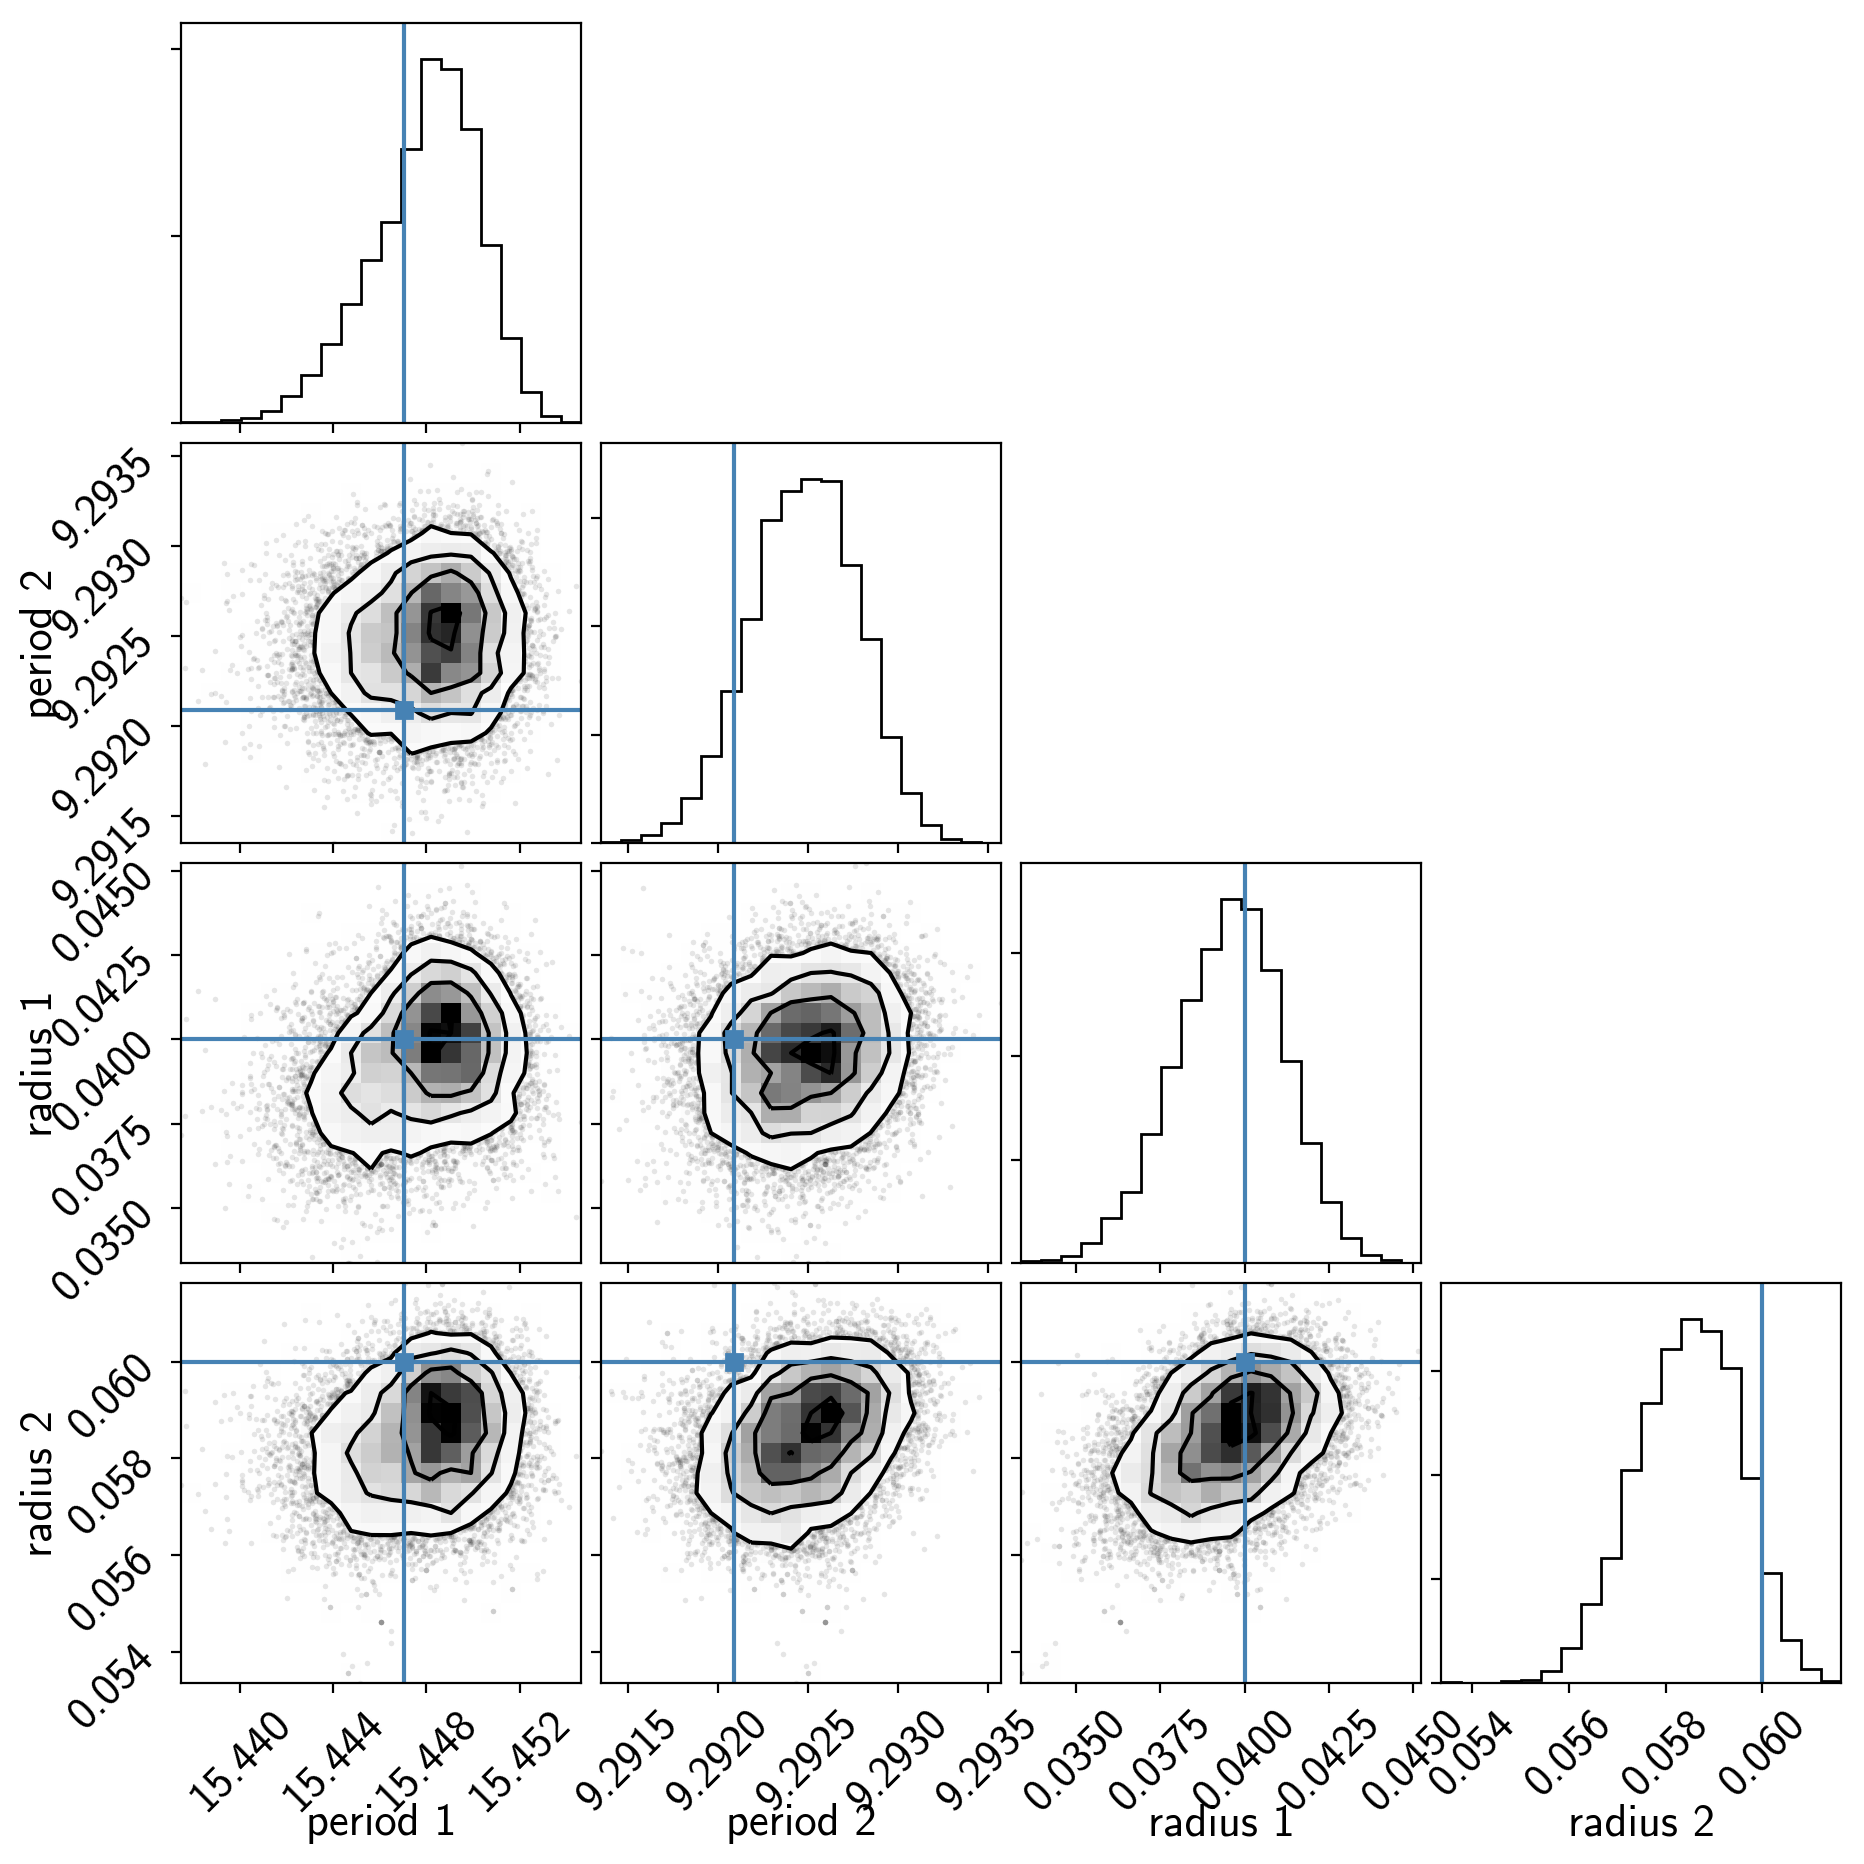

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

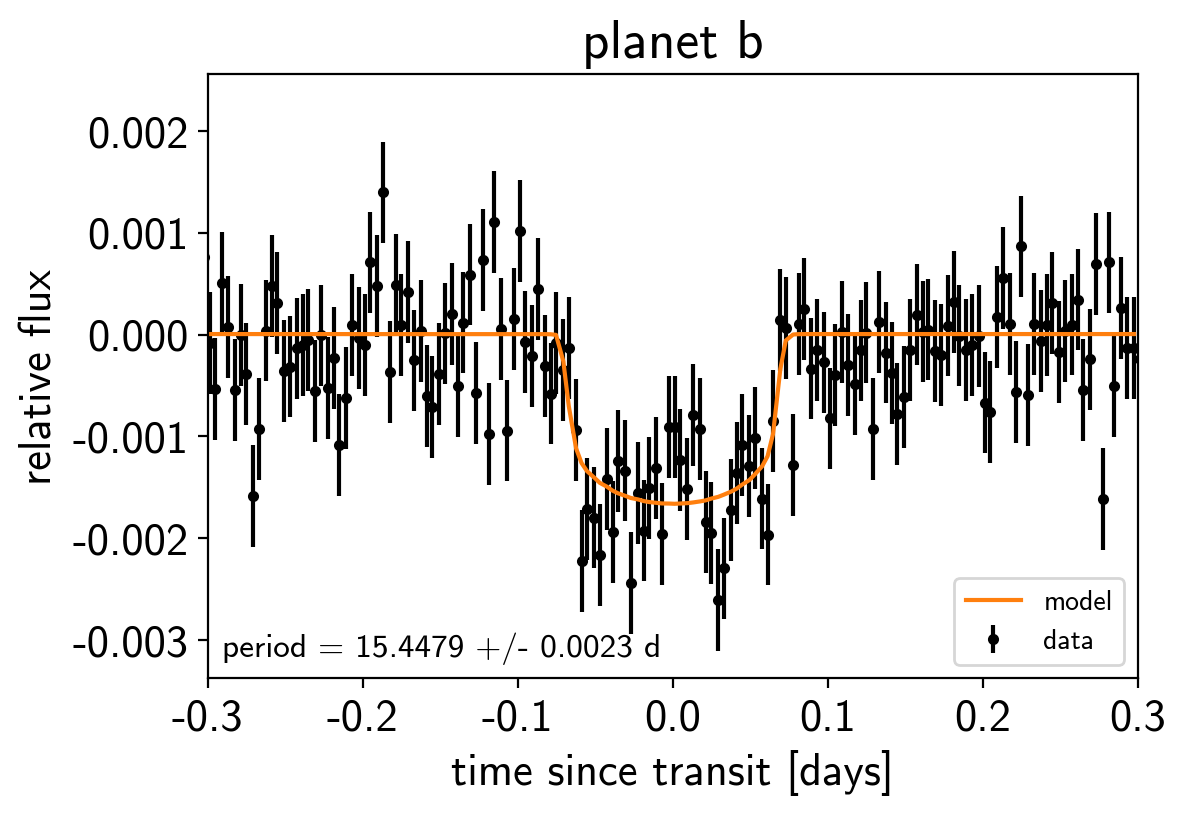

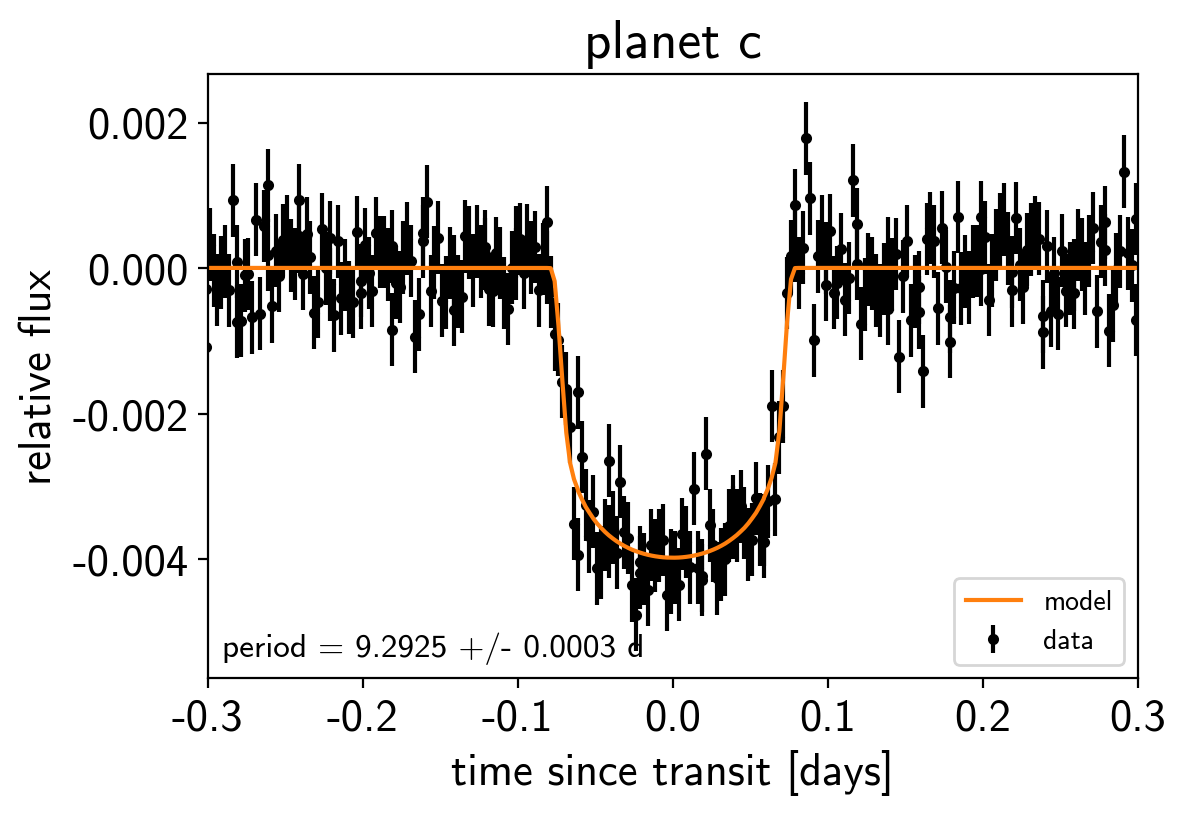

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
...
